In [1]:
#Import libraries & data

exec(open("../python/nb_setup.py").read())#Is there a better way to do this?

from IPython.core.display import display, HTML
from matplotlib.pyplot import *
style.use('../mplstyles/stylelib/standard.mplstyle')


from tqdm.notebook import tqdm
from scipy.optimize import fsolve
from scipy.special import erf
from scipy.interpolate import CubicSpline
import pickle as pkl
import sys
sys.path.append('../python')
import R68_yield as Yield
import R68_spec_tools as spec
import R68_plot_tools as pt
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.patches as mpatches

#Set up notebook and load some R68 constants (V, eps, etc.)
from constants import *

/var/folders/vn/rb46_y0s1tl360t6yzw8bjgr0000gn/T/ipykernel_99638/495547552.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


dict_keys(['xx', 'yy', 'ex', 'ey'])


In [2]:
#Function Definitions

#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

In [3]:
#Now run Sorensen

model_label='Sorensen'
fnames=['data/mcmc_Sor_128walk_50kstep_SNorm_v3.pkl',
        'data/mcmc_Sor_128walk_50kstep_SNorm_v4.pkl']

mcmc_datas=[]
for fname in fnames:
    with open(fname,'rb') as file:
        mcmc_datas.append(pkl.load(file))
RQss=[]
for datai in mcmc_datas:
    RQss.append(datai['RQs'])

In [4]:
#don't vectorize the function below. It already is, vectorizing will lead to bug https://github.com/numpy/numpy/issues/8758
#instead be sure to use np array only for argument!!
ySor = lambda E : Yield.ySor(E,0.151,1.96e-3) 

Et = np.asarray([33.,33,33,33,33,33,500,500,500,500,500,500,500,500,500,500.0,5000.0,500.0,500,500,500,500,500,500,500,6500.0,6500.0])
print(Et)
print(ySor(Et))

[  33.   33.   33.   33.   33.   33.  500.  500.  500.  500.  500.  500.
  500.  500.  500.  500. 5000.  500.  500.  500.  500.  500.  500.  500.
  500. 6500. 6500.]
[0.         0.         0.         0.         0.         0.
 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463
 0.03458463 0.03458463 0.03458463 0.03458463 0.25849808 0.03458463
 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463
 0.03458463 0.27455815 0.27455815]


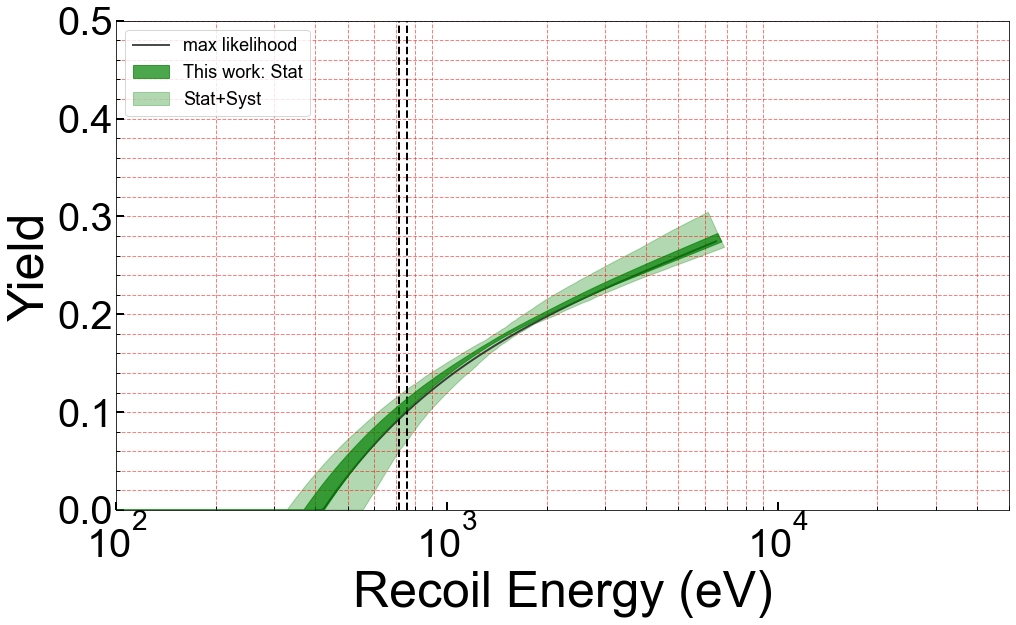

In [46]:
plt.figure(figsize=(16,9))

plot_fill_colors=['g','g']
plot_alphas=[0.7,0.3]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

vEr = np.linspace(400,6500,1000)
#print(ySor(vEr))

plt.plot(vEr,ySor(vEr),label="max likelihood",alpha=0.7,color='k',linewidth=2)

plt.axvline(754,color='k',linestyle="--")
plt.axvline(715,color='k',linestyle="--")
plt.grid(color='r', linestyle='--', linewidth=1,axis="y",which="both",alpha=0.5)
plt.grid(color='r', linestyle='--', linewidth=1,axis="x",which="Minor",alpha=0.5)

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    plt.fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])

plt.ylabel("Yield")
plt.xlabel("Recoil Energy (eV)")
#plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim([100,50000])
plt.ylim([0,0.5])
plt.xscale('log')

plt.legend(fontsize=18,loc='upper left')
plt.show()



In [6]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [60]:




for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))
    
    if(i==0):
      tight_band=Er_Ycalc_plot
      ytight=Ydist_plot
      cY = ytight<0
      ytight[cY]=0
    else:
      loose_band=Er_Ycalc_plot
      yloose=Ydist_plot
      cY = yloose<0
      yloose[cY]=0
    
    #print(np.shape(Er_Ycalc_plot))
    #print(np.shape(Ydist_plot))
    

#extract the tight band energies and yields on the high and low side
#vEr is the vector of energies corresponding to those high/low yields
vEr_low=tight_band[0:1001]
vEr_high=tight_band[1001:2002]
vEl=np.zeros(np.shape(vEr_low))
vEmid=np.zeros(np.shape(vEr_low))
vEh=np.zeros(np.shape(vEr_low))
vY=np.zeros(np.shape(vEr_low))
ytight_low = ytight[0:1001]
ytight_high = ytight[1001:2002] 

#because of how the polygon is encoded vEr and ytight_high need
#to be flipped
vEr_high=np.flip(vEr_high)
ytight_high=np.flip(ytight_high)


#get the mid point yield at a particular energy
#mid = (ytight_low+ytight_high)/2.0

#calculate the highest and lowest energies that intersect the yield bands at
#a particular yield 
for i,Er_low in enumerate(vEr_low):
    vY[i] = ySor(Er_low)
    Y0,j = find_nearest(ySor(vEr_low),vY[i])
    vEmid[i] = vEr_low[j]
    if i==612:
       print(vY[i])
       #print(ySor(vEr_low))
       print(vY[i],j,Er,vEr_low[j],Y0,ySor(Er))
    #print(i,vY[i])
    Y,j = find_nearest(ytight_low,vY[i])
    vEh[i] = vEr_low[j]
    if i==612:
       print(j)
    Y,j = find_nearest(ytight_high,vY[i])
    if i==612:
       print(j)
    vEl[i] = vEr_high[j]

print(np.shape(vEh))
print(np.shape(vEl))
print(vEr[450])
print(ySor(450))
print(find_nearest(ytight_high,ySor(450)))
print("{0:08.4f}\t{1:08.4f}\t{2:08.4f}".format(vEl[612],vEmid[612],vEh[612]))

print(np.shape(ytight_high))
print(np.shape(ytight_low))
 
mid = (ytight_low+ytight_high)/2.0

print(np.shape(mid))

print(np.shape(vEr))
print(vEr_low[1000])
print(ySor(754.28))
print(vEr_low[586],vEr_high[599])
print(ytight_high[586])
print(ytight_low[599])
Y,j = find_nearest(ytight_low,0.1003)
print(Y,j)
Y,j = find_nearest(ytight_high,0.1003)
print(Y,j)
print(ytight_low[580:602])
print(vEr[580:602])
print(ytight_low[999])
print(ytight_high[999])
#for i,Er in enumerate(vEr):
  
  #if(tb>367):
  #if(tb>328):
  #print("{0:08.4f}\t{1:05.4f}\t{2:05.4f}\t{3:05.4f}".format(Er,ytight_low[i],ytight_high[i],np.abs(ytight_high[i])))


0.10533834252200591
0.10533834252200591 612 6682.177393411446 783.300818327099 0.10533834252200591 0.2762568383765172
609
596
(1001,)
(1001,)
3147.747747747748
0.013894784086286777
(0.013843896035081602, 372)
706.7620	783.3008	774.4064
(1001,)
(1001,)
(1001,)
(1000,)
6770.15878864106
0.10029166407612215
712.5110801608525 715.28045814681
0.10053768241185886
0.10026290576700576
0.10026290576700576 599
0.10053768241185886 586
[0.09048752 0.09099591 0.09150487 0.09201439 0.09252575 0.09303807
 0.09355094 0.09406434 0.09457826 0.0950927  0.09560763 0.09612306
 0.09663897 0.09715535 0.09767219 0.09818948 0.09870721 0.09922536
 0.09974393 0.10026291 0.10078228 0.10130204]
[3941.54154154 3947.64764765 3953.75375375 3959.85985986 3965.96596597
 3972.07207207 3978.17817818 3984.28428428 3990.39039039 3996.4964965
 4002.6026026  4008.70870871 4014.81481481 4020.92092092 4027.02702703
 4033.13313313 4039.23923924 4045.34534535 4051.45145145 4057.55755756
 4063.66366366 4069.76976977]
0.27361486472

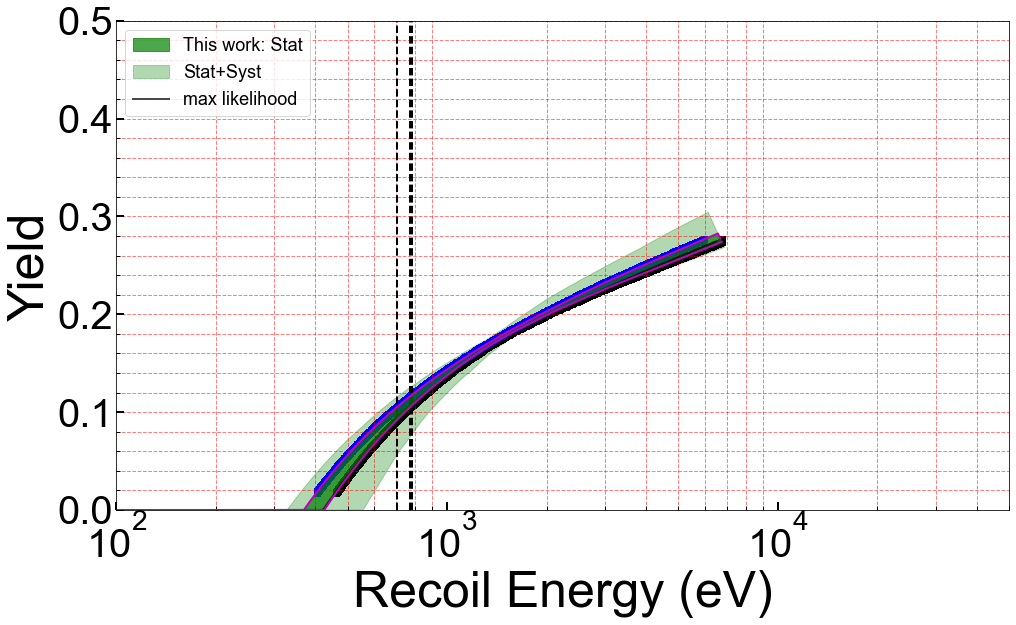

In [79]:
plt.figure(figsize=(16,9))

plot_fill_colors=['g','g']
plot_alphas=[0.7,0.3]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

vEr = np.linspace(400,6500,1000)
#print(ySor(vEr))


plt.axvline(783,color='k',linestyle="--")
plt.axvline(774,color='k',linestyle="--")
plt.axvline(706,color='k',linestyle="--")
plt.grid(color='r', linestyle='--', linewidth=1,axis="y",which="both",alpha=0.5)
plt.grid(color='r', linestyle='--', linewidth=1,axis="x",which="Minor",alpha=0.5)

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    plt.fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])

plt.plot(vEr,ySor(vEr),label="max likelihood",alpha=0.7,color='k')
plt.plot(np.flip(tight_band[1001:2002]),ytight_high,color="m",linewidth=2)
plt.plot(tight_band[0:1001],ytight_low,color="m",linewidth=2)

plt.scatter(vEh[400:1000],vY[400:1000],color='k',marker='s')
plt.scatter(vEl[400:1000],vY[400:1000],color='b',marker='s')

plt.ylabel("Yield")
plt.xlabel("Recoil Energy (eV)")
#plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim([100,50000])
plt.ylim([0,0.5])
plt.xscale('log')

plt.legend(fontsize=18,loc='upper left')
plt.show()

In [8]:
#let's do it in close to the xml format

print("\t<data-format>Mathematica</data-format>")
print("\t<data-values>")
print("\t{")

for i,Er in enumerate(vEr):
  
    print("\t{{{0:08.4f},{1:05.4f}}},".format(Er,ySor(Er)))
          
          
print("\t}")
print("\t<data-values>")

	<data-format>Mathematica</data-format>
	<data-values>
	{
	{033.8947,0.0000},
	{034.1536,0.0000},
	{034.4145,0.0000},
	{034.6773,0.0000},
	{034.9421,0.0000},
	{035.2090,0.0000},
	{035.4779,0.0000},
	{035.7489,0.0000},
	{036.0219,0.0000},
	{036.2970,0.0000},
	{036.5743,0.0000},
	{036.8536,0.0000},
	{037.1351,0.0000},
	{037.4187,0.0000},
	{037.7045,0.0000},
	{037.9924,0.0000},
	{038.2826,0.0000},
	{038.5750,0.0000},
	{038.8696,0.0000},
	{039.1665,0.0000},
	{039.4656,0.0000},
	{039.7670,0.0000},
	{040.0708,0.0000},
	{040.3768,0.0000},
	{040.6852,0.0000},
	{040.9959,0.0000},
	{041.3090,0.0000},
	{041.6245,0.0000},
	{041.9424,0.0000},
	{042.2628,0.0000},
	{042.5856,0.0000},
	{042.9108,0.0000},
	{043.2385,0.0000},
	{043.5688,0.0000},
	{043.9015,0.0000},
	{044.2368,0.0000},
	{044.5747,0.0000},
	{044.9151,0.0000},
	{045.2582,0.0000},
	{045.6038,0.0000},
	{045.9521,0.0000},
	{046.3031,0.0000},
	{046.6567,0.0000},
	{047.0131,0.0000},
	{047.3721,0.0000},
	{047.7339,0.0000},
	{048.0985,0.0000},
	{